In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
import matplotlib.pyplot as plt

In [40]:
weather_data = pd.read_csv("api_weather_data_toronto.csv", index_col=[0])

# set up target y
weather_data["target_2m_temp"] = weather_data["temperature_2m"].shift(-1)
weather_data = weather_data.dropna(subset=["target_2m_temp"])  # Drop rows where target is NaN
print(f"Dataset shape: {weather_data.shape}")


Dataset shape: (17543, 17)


In [41]:
# LSTM SEQUENCE
def create_sequences(data, target, sequence_length=48):
    """
    Create sequences for LSTM training
    sequence_length: number of previous hours to use for prediction
    """
    X, y = [], []
    
    for i in range(sequence_length, len(data)):
        # Use past 'sequence_length' hours to predict next temperature
        X.append(data[i-sequence_length:i])
        y.append(target.iloc[i])
    
    return np.array(X), np.array(y)

In [42]:
feature_columns = ['temperature_2m', 'dew_point_2m', 'precipitation', 
                  'weather_code', 'wind_speed_120m', 'wind_direction_80m', 
                  'visibility', 'relative_humidity_2m', 'month_cos',
                  'DayOfWeek', 'hour', 'day_cos']

features = weather_data[feature_columns]
target = weather_data["target_2m_temp"]
features = features.fillna(method='ffill').fillna(method='bfill')

/tmp/ipykernel_117865/1949044219.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill').fillna(method='bfill')


In [43]:
# Normalize features BEFORE creating sequences
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [44]:
SEQUENCE_LENGTH = 24
X, y = create_sequences(features_scaled, target, SEQUENCE_LENGTH)
print(f"Sequence shape: {X.shape}")  # Should be (samples, sequence_length, features)
print(f"Target shape: {y.shape}")    # Should be (samples,)

Sequence shape: (17519, 24, 12)
Target shape: (17519,)


In [45]:
# Split 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [46]:
model = Sequential([
    # First LSTM layer - returns sequences for stacking
    LSTM(64, return_sequences=True, input_shape=(SEQUENCE_LENGTH, len(feature_columns))),
    Dropout(0.3),
    
    # Second LSTM layer - returns single output
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    
    # Dense layers for final prediction
    Dense(16, activation='relu'),
    BatchNormalization(),
    
    Dense(1)  # Single output for temperature prediction
])

/home/python/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)
history = model.fit(
    X_train, y_train, 
    epochs=200,  # More epochs, but early stopping will control
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 125.6744 - mae: 8.9493 - val_loss: 268.5447 - val_mae: 15.2615
Epoch 2/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 102.9792 - mae: 8.4906 - val_loss: 192.4786 - val_mae: 12.9642
Epoch 3/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 95.0745 - mae: 8.2609 - val_loss: 159.0005 - val_mae: 11.8263
Epoch 4/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 88.3320 - mae: 8.0579 - val_loss: 146.0573 - val_mae: 11.4004
Epoch 5/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 81.8819 - mae: 7.8455 - val_loss: 130.9375 - val_mae: 10.8537
Epoch 6/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 75.9832 - mae: 7.6370 - val_loss: 115.0895 - val_mae: 10.1859
Epoch 7/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 70.8098 - mae: 7.4299 - val_loss: 99.8582 - val_mae: 9.4848
Epoch 8/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 65.4697 - mae: 7.2154 - val_loss: 92.9213 - val_mae: 9.1690
Epoch 9/20

In [48]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3682 - mae: 1.1896
Test Loss: 2.3682
Test MAE: 1.1896


In [51]:
model.save("models/LSTM.keras")

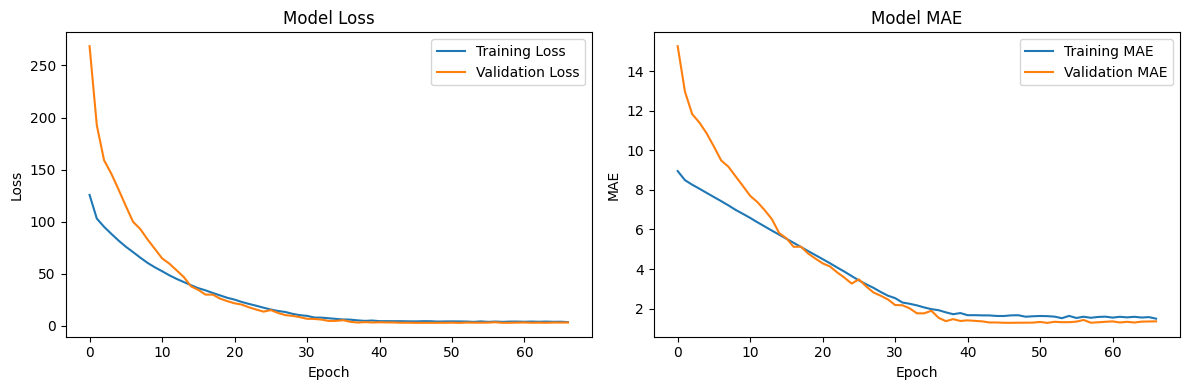

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


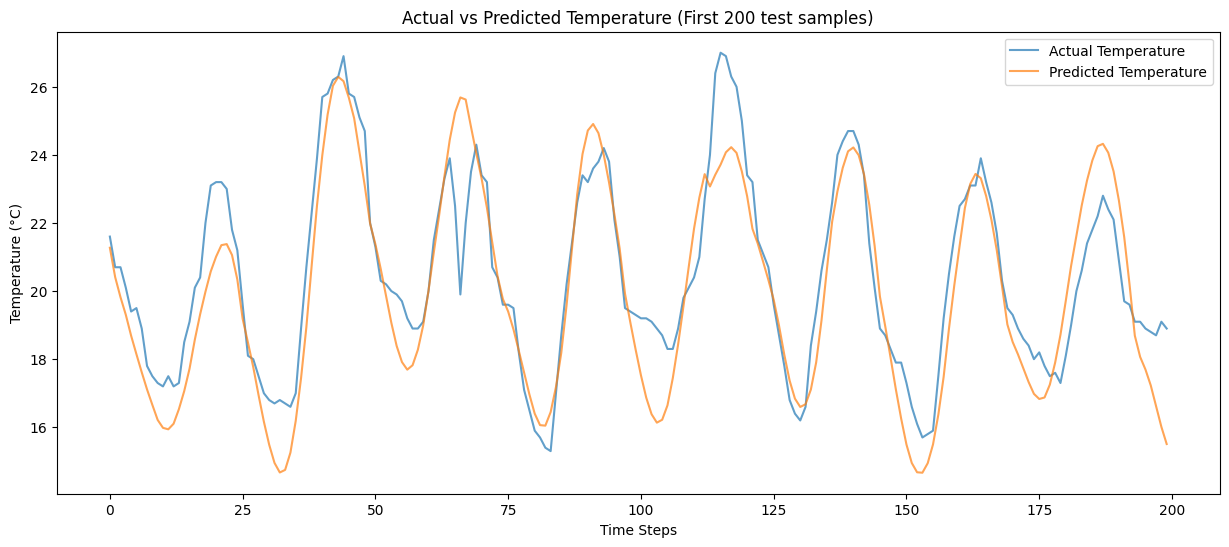

In [55]:
# Cell 9: Plot training history (NEW)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Cell 10: Make predictions and visualize (NEW)
predictions = model.predict(X_test)

# Plot actual vs predicted for a subset
plt.figure(figsize=(15, 6))
n_samples = 200  # Show first 200 test predictions
plt.plot(y_test[:n_samples], label='Actual Temperature', alpha=0.7)
plt.plot(predictions[:n_samples], label='Predicted Temperature', alpha=0.7)
plt.title('Actual vs Predicted Temperature (First 200 test samples)')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()